In [152]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [153]:
class FCLayer:
    """
    This class implements a fully connected layer for the neural network
    input_size : int
        size of the input layer
    output_size : int
        size of the output layer
    init_method : str
        weights initialization method ['random', 'he', 'xavier']
    """
    def __init__(self, input_size, output_size, init_method):
        self.input_size = input_size
        self.output_size = output_size
        self.init_method = init_method
        self.weights = self.initialize_params('weights')
        self.bias = self.initialize_params('biases')
        
    def initialize_params(self, param):
        params = []
        
        if self.init_method == "random":
            if param == 'weights':
                params = np.random.randn(self.input_size, self.output_size)*0.01 # divide by 100 to avoid exploding gradients leading to overflow
            else:
                params = np.random.randn(1,self.output_size)
                
        elif self.init_method == "xavier":
            if param == 'weights':
                params = np.random.randn(self.input_size,self.output_size)*np.sqrt(1/self.input_size)
            else:
                params = np.random.randn(1,self.output_size)

        elif self.init_method == "he":
            if param == 'weights':
                params = np.random.randn(self.input_size,self.output_size)*np.sqrt(2/self.input_size)
            else:
                params = np.random.randn(1,self.output_size)

        return params
        

    def forward_pass(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward_pass(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [154]:
class ActivationLayer:
    """
    This class implements an activation layer
    Attributes
    ----------
    activation_function : str
        type of the activation function to be used by the given network ['sigmoid', 'tanh', 'relu', 'leaky_relu']
    leaky_rate : float
        slope of the function to be used by the leaky_relu activation function
    """
    def __init__(self, activation_function, leaky_rate=0.1):
        self.activation_function = activation_function
        self.leaky_rate = leaky_rate
    
    def forward_pass(self, input):
        self.input = input
        return self.activation(input)
    
    def backward_pass(self, output_error, learning_rate):
        return output_error * self.activation(self.input, derivative=True)
    
    def activation(self, X, derivative=False):
        if self.activation_function == "sigmoid":
            if derivative:
                return np.exp(-X) / (1.0 + np.exp(-X))**2.0
            return 1.0/(1.0 + np.exp(-X))
        elif self.activation_function == "tanh":
            if derivative:
                return 1 - np.tanh(X)**2.0
            return np.tanh(X)
        elif self.activation_function == "relu":
            if derivative:
                return 1.0*(X>=0)
            return np.maximum(0,X)
        elif self.activation_function == "leaky_relu":
            if derivative:
                d=np.zeros_like(X)
                d[X<=0]=self.leaky_rate
                d[X>0]=1
                return d
            return np.maximum(self.leaky_rate*X,X)

In [155]:
class FlattenLayer:
    """
    Class implementing a flattening layer
    This layer is used as the first one in the NN and its task is to flatten the input arrays
    """
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward_pass(self, input):
        return np.reshape(input, (1, -1))
    
    def backward_pass(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

In [156]:
class Softmax:
    """
    Class implementing the softmax activation function which is used as the last layer in the NN for the multiclass classification problem 
    """
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward_pass(self, input):
        self.input = input
        exp = np.exp(input)
        self.output = exp / np.sum(exp)
        return self.output
    
    def backward_pass(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

In [157]:
# function performing loss calculation
def loss_function(y_true, y_pred, function, backward_pass=False):
    if function == 'mse':
        if backward_pass:
            return 2 * (y_pred - y_true) / y_pred.size
        else:
            return np.square(np.subtract(y_true,y_pred)).mean()
    """ not a correct implementation
    if function == 'multiclass_crossentropy':
        loss=-np.sum(y_true*np.log(y_pred))
        return loss/float(y_pred.shape[0])
    """

In [158]:
class NeuralNetwork():
    """
    This class implements a Feed Forward Neural Network.
    The model is highly configurable and allows for the experimentation with different learning architectures.
    ...

    Attributes
    ----------
    epochs : int
        number of epochs to run training for
    lr : float
        learning rate used for training
    activation_function : str
        activation function to be used by the model ['sigmoid', 'tanh', 'relu', leaky_relu']
    leaky_rate : float
        slope of the leaky relu function (only used when activation_function='leaky_relu')


    Methods
    -------
    add(self, layer)
        adds the passed as the input layer to the model
    fit(self, x_train, y_train, loss)
        Trains the network on the input training data by performing forward pass and backpropagation
    predict(self, x)
        runs the forward pass on the input provided and returns the prediction
    compute_accuracy(self, x_test, y_test)
        computes the accuracy on the dataset provided
    visualize_learning(self)
        plots the loss as a function of epochs passed
    """
    def __init__(self, epochs, lr):
        self.epochs = epochs
        self.lr = lr
        self.layers = []
        self.errors = []
        
    def add(self, layer):
        self.layers.append(layer)
            
    def fit(self, x_train, y_train, loss):
        start_time = time.time()
        # iterate for the desired number of operations
        for epoch in range(self.epochs):
            # initialize error
            error = 0
            # run for each sample in the training dataset
            for x, y in zip(x_train, y_train):
                # feedforward
                output = self.predict(x)
                # update error
                error += loss_function(y, output, loss)
                # backpropagation
                output_error = loss_function(y, output, loss, True)
                for layer in reversed(self.layers):
                    output_error = layer.backward_pass(output_error, learning_rate)
            # get the mean of the error across all samples
            error /= len(x_train)
            # add for plotting
            self.errors.append(error)
            print('Epoch: {0}, Time Spent: {1:.2f}s, {2} loss: {3:.6f}'.format(epoch+1, time.time() - start_time, loss, error))
        
    def predict(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward_pass(output)
        return output
    
    def compute_accuracy(self, x_test, y_test):
        predictions = []

        for x, y in zip(x_test, y_test):
            output = self.predict(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)
            
    def visualize_learning(self):
        a4_dims = (11.7, 8.27)
        plt.figure(figsize=a4_dims)
        plt.plot([i for i in range(self.epochs)], [i for i in self.errors], color='red')

        plt.suptitle('Error per epoch', fontsize=12)
        plt.xlabel("Epoch")
        plt.ylabel("MSE")            

In [173]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_train /= 255
y_train = np_utils.to_categorical(y_train)
x_train = x_train[0:1000]
y_train = y_train[0:1000]

x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

epochs = 30
lr = 0.01
n_classes = 10

## Sigmoid activation

Epoch: 1, Time Spent: 0.50s, mse loss: 0.092430
Epoch: 2, Time Spent: 0.88s, mse loss: 0.090649
Epoch: 3, Time Spent: 1.28s, mse loss: 0.090353
Epoch: 4, Time Spent: 1.67s, mse loss: 0.090189
Epoch: 5, Time Spent: 2.06s, mse loss: 0.090184
Epoch: 6, Time Spent: 2.40s, mse loss: 0.090182
Epoch: 7, Time Spent: 2.75s, mse loss: 0.090181
Epoch: 8, Time Spent: 3.10s, mse loss: 0.090179
Epoch: 9, Time Spent: 3.44s, mse loss: 0.090178
Epoch: 10, Time Spent: 3.79s, mse loss: 0.090176
Epoch: 11, Time Spent: 4.14s, mse loss: 0.090175
Epoch: 12, Time Spent: 4.49s, mse loss: 0.090173
Epoch: 13, Time Spent: 4.83s, mse loss: 0.090172
Epoch: 14, Time Spent: 5.18s, mse loss: 0.090170
Epoch: 15, Time Spent: 5.56s, mse loss: 0.090169
Epoch: 16, Time Spent: 5.93s, mse loss: 0.090167
Epoch: 17, Time Spent: 6.29s, mse loss: 0.090165
Epoch: 18, Time Spent: 6.65s, mse loss: 0.090164
Epoch: 19, Time Spent: 7.03s, mse loss: 0.090162
Epoch: 20, Time Spent: 7.38s, mse loss: 0.090160
Epoch: 21, Time Spent: 7.75s,

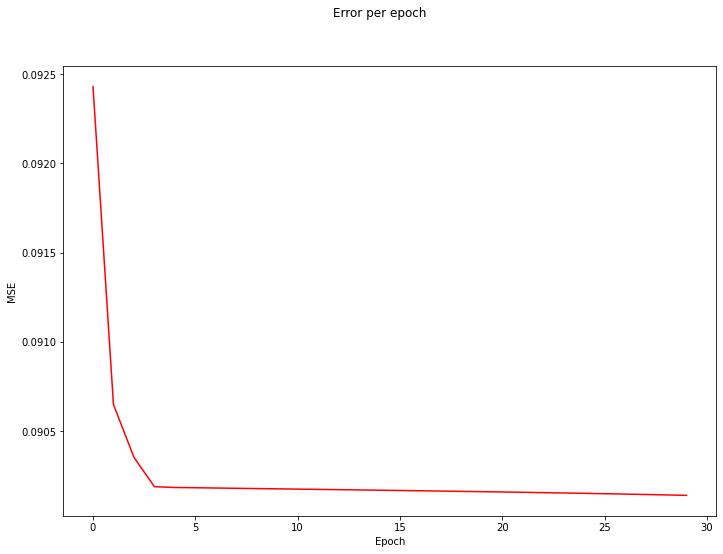

In [186]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'random'))
dnn.add(ActivationLayer('sigmoid'))
dnn.add(FCLayer(128, 64, 'random'))
dnn.add(ActivationLayer('sigmoid'))
dnn.add(FCLayer(64, n_classes, 'random'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

Epoch: 1, Time Spent: 0.41s, mse loss: 0.092778
Epoch: 2, Time Spent: 0.76s, mse loss: 0.089751
Epoch: 3, Time Spent: 1.14s, mse loss: 0.089192
Epoch: 4, Time Spent: 1.59s, mse loss: 0.088662
Epoch: 5, Time Spent: 2.22s, mse loss: 0.088000
Epoch: 6, Time Spent: 2.78s, mse loss: 0.087125
Epoch: 7, Time Spent: 3.28s, mse loss: 0.085904
Epoch: 8, Time Spent: 3.70s, mse loss: 0.084118
Epoch: 9, Time Spent: 4.11s, mse loss: 0.081467
Epoch: 10, Time Spent: 4.49s, mse loss: 0.077735
Epoch: 11, Time Spent: 4.89s, mse loss: 0.073065
Epoch: 12, Time Spent: 5.33s, mse loss: 0.067881
Epoch: 13, Time Spent: 5.74s, mse loss: 0.062544
Epoch: 14, Time Spent: 6.14s, mse loss: 0.057276
Epoch: 15, Time Spent: 6.51s, mse loss: 0.052261
Epoch: 16, Time Spent: 6.88s, mse loss: 0.047657
Epoch: 17, Time Spent: 7.24s, mse loss: 0.043544
Epoch: 18, Time Spent: 7.59s, mse loss: 0.039897
Epoch: 19, Time Spent: 7.96s, mse loss: 0.036639
Epoch: 20, Time Spent: 8.32s, mse loss: 0.033692
Epoch: 21, Time Spent: 8.68s,

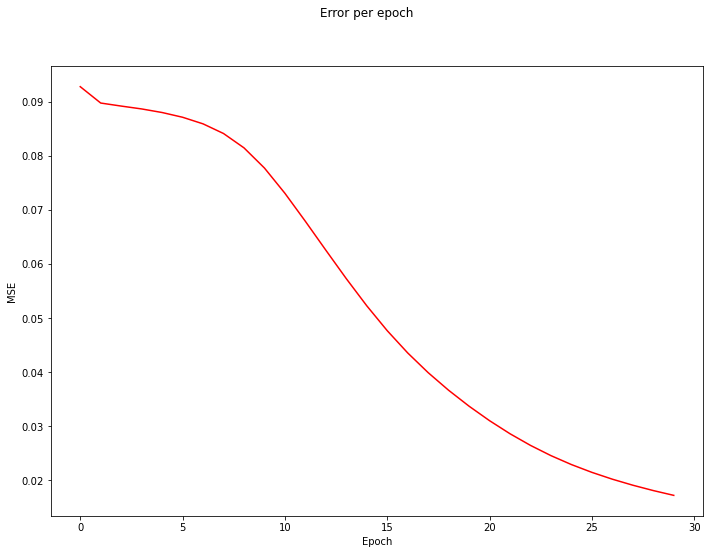

In [175]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'he'))
dnn.add(ActivationLayer('sigmoid'))
dnn.add(FCLayer(128, 64, 'he'))
dnn.add(ActivationLayer('sigmoid'))
dnn.add(FCLayer(64, n_classes, 'he'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

Epoch: 1, Time Spent: 0.42s, mse loss: 0.092229
Epoch: 2, Time Spent: 0.79s, mse loss: 0.090241
Epoch: 3, Time Spent: 1.15s, mse loss: 0.089957
Epoch: 4, Time Spent: 1.52s, mse loss: 0.089828
Epoch: 5, Time Spent: 1.88s, mse loss: 0.089691
Epoch: 6, Time Spent: 2.25s, mse loss: 0.089536
Epoch: 7, Time Spent: 2.60s, mse loss: 0.089355
Epoch: 8, Time Spent: 2.96s, mse loss: 0.089139
Epoch: 9, Time Spent: 3.34s, mse loss: 0.088872
Epoch: 10, Time Spent: 3.71s, mse loss: 0.088535
Epoch: 11, Time Spent: 4.08s, mse loss: 0.088094
Epoch: 12, Time Spent: 4.44s, mse loss: 0.087494
Epoch: 13, Time Spent: 4.82s, mse loss: 0.086641
Epoch: 14, Time Spent: 5.19s, mse loss: 0.085373
Epoch: 15, Time Spent: 5.57s, mse loss: 0.083468
Epoch: 16, Time Spent: 5.95s, mse loss: 0.080820
Epoch: 17, Time Spent: 6.33s, mse loss: 0.077736
Epoch: 18, Time Spent: 6.71s, mse loss: 0.074675
Epoch: 19, Time Spent: 7.08s, mse loss: 0.071767
Epoch: 20, Time Spent: 7.44s, mse loss: 0.068866
Epoch: 21, Time Spent: 7.83s,

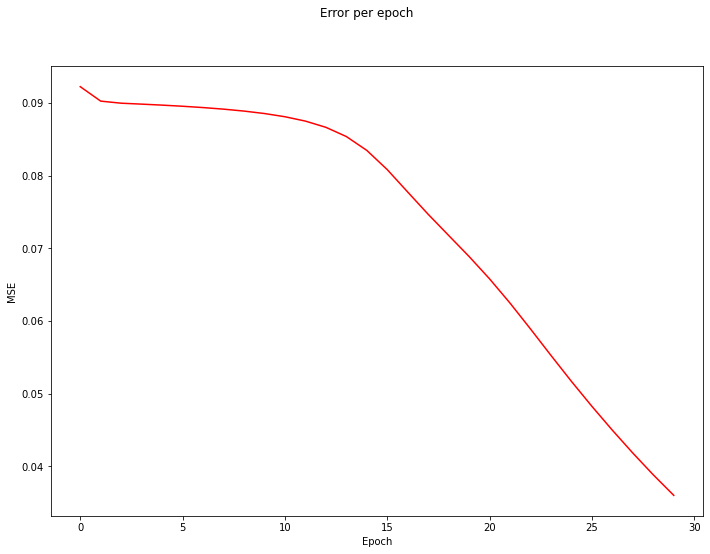

In [176]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'xavier'))
dnn.add(ActivationLayer('sigmoid'))
dnn.add(FCLayer(128, 64, 'xavier'))
dnn.add(ActivationLayer('sigmoid'))
dnn.add(FCLayer(64, n_classes, 'xavier'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

## ReLu activation

Epoch: 1, Time Spent: 0.50s, mse loss: 0.091159
Epoch: 2, Time Spent: 0.95s, mse loss: 0.090503
Epoch: 3, Time Spent: 1.35s, mse loss: 0.090390
Epoch: 4, Time Spent: 1.76s, mse loss: 0.090233
Epoch: 5, Time Spent: 2.14s, mse loss: 0.089911
Epoch: 6, Time Spent: 2.51s, mse loss: 0.088901
Epoch: 7, Time Spent: 2.88s, mse loss: 0.085168
Epoch: 8, Time Spent: 3.25s, mse loss: 0.080627
Epoch: 9, Time Spent: 3.62s, mse loss: 0.076542
Epoch: 10, Time Spent: 3.98s, mse loss: 0.073870
Epoch: 11, Time Spent: 4.34s, mse loss: 0.071699
Epoch: 12, Time Spent: 4.70s, mse loss: 0.069517
Epoch: 13, Time Spent: 5.07s, mse loss: 0.065023
Epoch: 14, Time Spent: 5.43s, mse loss: 0.056784
Epoch: 15, Time Spent: 5.80s, mse loss: 0.050252
Epoch: 16, Time Spent: 6.16s, mse loss: 0.043121
Epoch: 17, Time Spent: 6.53s, mse loss: 0.036224
Epoch: 18, Time Spent: 6.88s, mse loss: 0.030885
Epoch: 19, Time Spent: 7.25s, mse loss: 0.025636
Epoch: 20, Time Spent: 7.66s, mse loss: 0.021045
Epoch: 21, Time Spent: 8.04s,

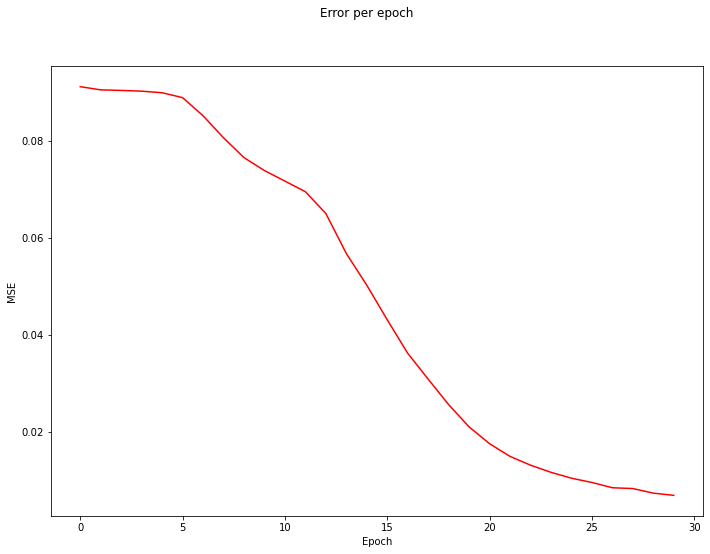

In [177]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'random'))
dnn.add(ActivationLayer('relu'))
dnn.add(FCLayer(128, 64, 'random'))
dnn.add(ActivationLayer('relu'))
dnn.add(FCLayer(64, n_classes, 'random'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

Epoch: 1, Time Spent: 0.45s, mse loss: 0.069347
Epoch: 2, Time Spent: 0.83s, mse loss: 0.029562
Epoch: 3, Time Spent: 1.20s, mse loss: 0.019736
Epoch: 4, Time Spent: 1.58s, mse loss: 0.014929
Epoch: 5, Time Spent: 1.95s, mse loss: 0.011636
Epoch: 6, Time Spent: 2.37s, mse loss: 0.009065
Epoch: 7, Time Spent: 2.76s, mse loss: 0.007058
Epoch: 8, Time Spent: 3.20s, mse loss: 0.005984
Epoch: 9, Time Spent: 3.56s, mse loss: 0.005051
Epoch: 10, Time Spent: 3.92s, mse loss: 0.004631
Epoch: 11, Time Spent: 4.29s, mse loss: 0.004122
Epoch: 12, Time Spent: 4.68s, mse loss: 0.003820
Epoch: 13, Time Spent: 5.06s, mse loss: 0.003494
Epoch: 14, Time Spent: 5.44s, mse loss: 0.003247
Epoch: 15, Time Spent: 5.81s, mse loss: 0.003088
Epoch: 16, Time Spent: 6.19s, mse loss: 0.002903
Epoch: 17, Time Spent: 6.59s, mse loss: 0.002780
Epoch: 18, Time Spent: 6.98s, mse loss: 0.002777
Epoch: 19, Time Spent: 7.36s, mse loss: 0.002759
Epoch: 20, Time Spent: 7.75s, mse loss: 0.002512
Epoch: 21, Time Spent: 8.19s,

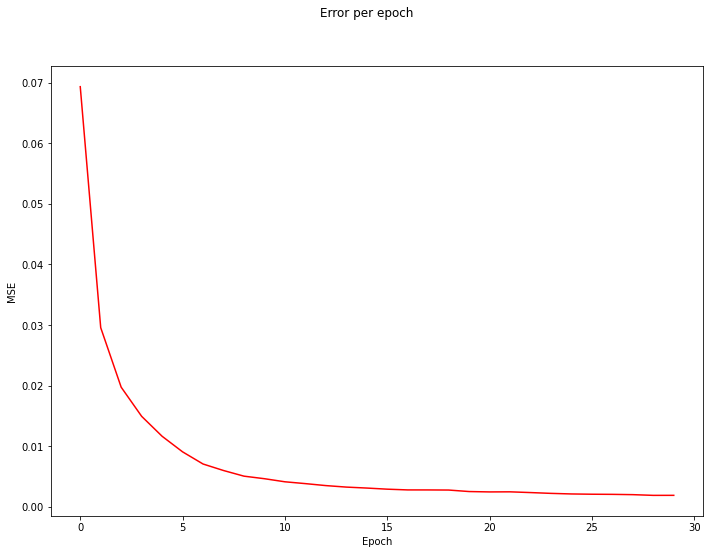

In [178]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'he'))
dnn.add(ActivationLayer('relu'))
dnn.add(FCLayer(128, 64, 'he'))
dnn.add(ActivationLayer('relu'))
dnn.add(FCLayer(64, n_classes, 'he'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

Epoch: 1, Time Spent: 1.06s, mse loss: 0.078556
Epoch: 2, Time Spent: 2.32s, mse loss: 0.042313
Epoch: 3, Time Spent: 3.69s, mse loss: 0.024297
Epoch: 4, Time Spent: 5.19s, mse loss: 0.017774
Epoch: 5, Time Spent: 6.95s, mse loss: 0.013811
Epoch: 6, Time Spent: 8.39s, mse loss: 0.010964
Epoch: 7, Time Spent: 9.79s, mse loss: 0.009039
Epoch: 8, Time Spent: 10.86s, mse loss: 0.007695
Epoch: 9, Time Spent: 12.04s, mse loss: 0.006614
Epoch: 10, Time Spent: 13.57s, mse loss: 0.005811
Epoch: 11, Time Spent: 14.46s, mse loss: 0.005181
Epoch: 12, Time Spent: 15.22s, mse loss: 0.004599
Epoch: 13, Time Spent: 15.91s, mse loss: 0.004222
Epoch: 14, Time Spent: 16.55s, mse loss: 0.003869
Epoch: 15, Time Spent: 17.11s, mse loss: 0.003588
Epoch: 16, Time Spent: 17.66s, mse loss: 0.003271
Epoch: 17, Time Spent: 18.20s, mse loss: 0.003047
Epoch: 18, Time Spent: 18.70s, mse loss: 0.002753
Epoch: 19, Time Spent: 19.19s, mse loss: 0.002558
Epoch: 20, Time Spent: 19.64s, mse loss: 0.002453
Epoch: 21, Time 

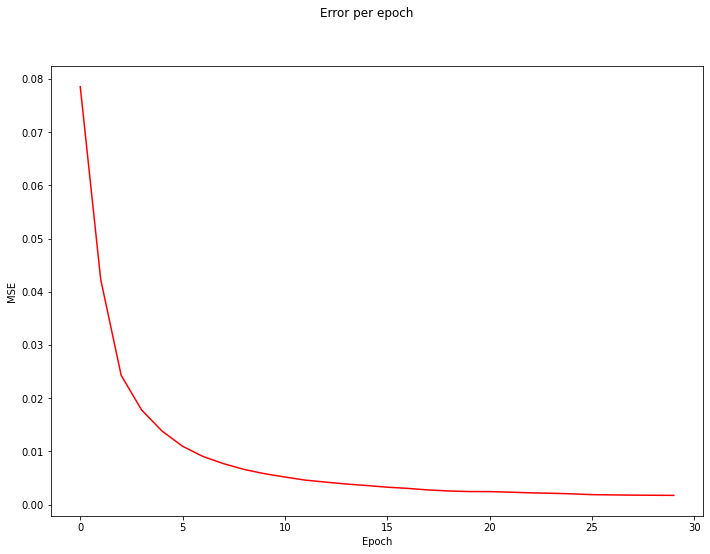

In [179]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'xavier'))
dnn.add(ActivationLayer('relu'))
dnn.add(FCLayer(128, 64, 'xavier'))
dnn.add(ActivationLayer('relu'))
dnn.add(FCLayer(64, n_classes, 'xavier'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

## Leaky ReLu activation

Epoch: 1, Time Spent: 0.48s, mse loss: 0.091299
Epoch: 2, Time Spent: 0.87s, mse loss: 0.090480
Epoch: 3, Time Spent: 1.25s, mse loss: 0.090377
Epoch: 4, Time Spent: 1.64s, mse loss: 0.090241
Epoch: 5, Time Spent: 2.02s, mse loss: 0.089984
Epoch: 6, Time Spent: 2.40s, mse loss: 0.089258
Epoch: 7, Time Spent: 2.80s, mse loss: 0.086144
Epoch: 8, Time Spent: 3.19s, mse loss: 0.082465
Epoch: 9, Time Spent: 3.57s, mse loss: 0.080645
Epoch: 10, Time Spent: 3.97s, mse loss: 0.079333
Epoch: 11, Time Spent: 4.37s, mse loss: 0.077680
Epoch: 12, Time Spent: 4.77s, mse loss: 0.074849
Epoch: 13, Time Spent: 5.18s, mse loss: 0.071357
Epoch: 14, Time Spent: 5.58s, mse loss: 0.067887
Epoch: 15, Time Spent: 5.99s, mse loss: 0.063054
Epoch: 16, Time Spent: 6.41s, mse loss: 0.057869
Epoch: 17, Time Spent: 6.84s, mse loss: 0.051638
Epoch: 18, Time Spent: 7.26s, mse loss: 0.043795
Epoch: 19, Time Spent: 7.69s, mse loss: 0.037680
Epoch: 20, Time Spent: 8.13s, mse loss: 0.032428
Epoch: 21, Time Spent: 8.61s,

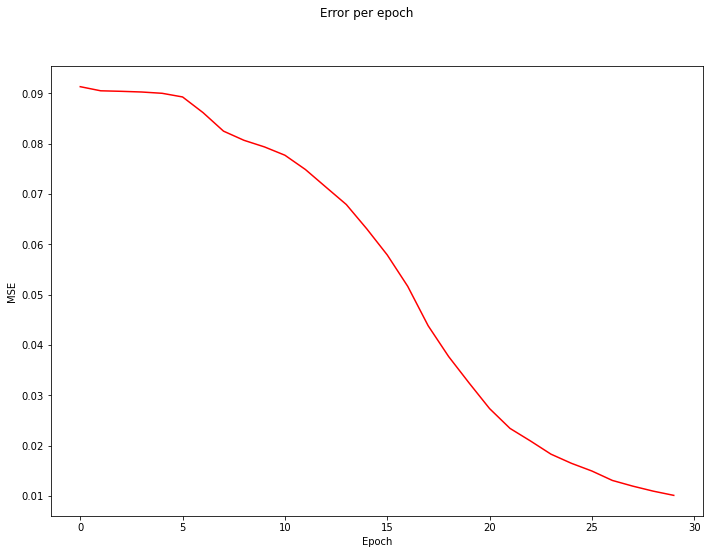

In [180]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'random'))
dnn.add(ActivationLayer('leaky_relu', 0.1))
dnn.add(FCLayer(128, 64, 'random'))
dnn.add(ActivationLayer('leaky_relu', 0.1))
dnn.add(FCLayer(64, n_classes, 'random'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

Epoch: 1, Time Spent: 0.66s, mse loss: 0.063917
Epoch: 2, Time Spent: 1.23s, mse loss: 0.027721
Epoch: 3, Time Spent: 1.70s, mse loss: 0.017754
Epoch: 4, Time Spent: 2.17s, mse loss: 0.013135
Epoch: 5, Time Spent: 2.63s, mse loss: 0.009763
Epoch: 6, Time Spent: 3.08s, mse loss: 0.007821
Epoch: 7, Time Spent: 3.58s, mse loss: 0.006365
Epoch: 8, Time Spent: 4.02s, mse loss: 0.005344
Epoch: 9, Time Spent: 4.47s, mse loss: 0.004683
Epoch: 10, Time Spent: 4.96s, mse loss: 0.004260
Epoch: 11, Time Spent: 5.45s, mse loss: 0.003852
Epoch: 12, Time Spent: 5.90s, mse loss: 0.003479
Epoch: 13, Time Spent: 6.38s, mse loss: 0.003298
Epoch: 14, Time Spent: 6.97s, mse loss: 0.003041
Epoch: 15, Time Spent: 7.51s, mse loss: 0.002901
Epoch: 16, Time Spent: 7.96s, mse loss: 0.002798
Epoch: 17, Time Spent: 8.38s, mse loss: 0.002733
Epoch: 18, Time Spent: 8.80s, mse loss: 0.002611
Epoch: 19, Time Spent: 9.22s, mse loss: 0.002538
Epoch: 20, Time Spent: 9.64s, mse loss: 0.002443
Epoch: 21, Time Spent: 10.06s

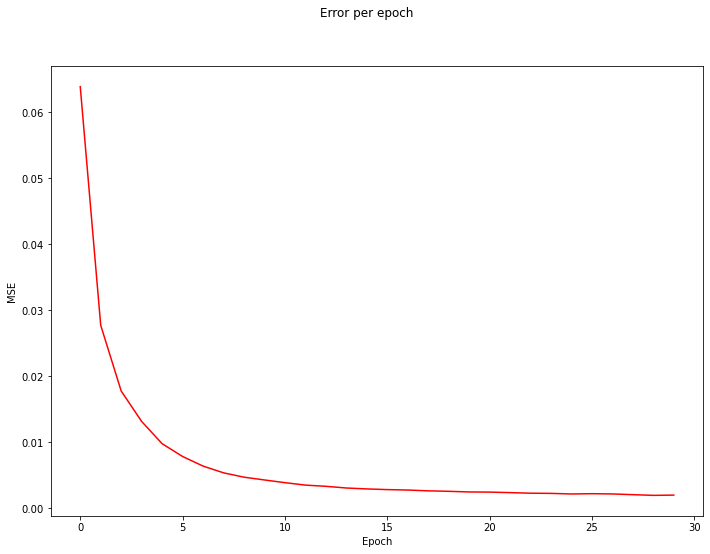

In [181]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'he'))
dnn.add(ActivationLayer('leaky_relu', 0.1))
dnn.add(FCLayer(128, 64, 'he'))
dnn.add(ActivationLayer('leaky_relu', 0.1))
dnn.add(FCLayer(64, n_classes, 'he'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

Epoch: 1, Time Spent: 0.57s, mse loss: 0.081968
Epoch: 2, Time Spent: 0.98s, mse loss: 0.046991
Epoch: 3, Time Spent: 1.38s, mse loss: 0.027824
Epoch: 4, Time Spent: 1.77s, mse loss: 0.019804
Epoch: 5, Time Spent: 2.17s, mse loss: 0.015431
Epoch: 6, Time Spent: 2.58s, mse loss: 0.012368
Epoch: 7, Time Spent: 2.98s, mse loss: 0.010065
Epoch: 8, Time Spent: 3.39s, mse loss: 0.008361
Epoch: 9, Time Spent: 3.79s, mse loss: 0.007137
Epoch: 10, Time Spent: 4.20s, mse loss: 0.006072
Epoch: 11, Time Spent: 4.60s, mse loss: 0.005262
Epoch: 12, Time Spent: 5.02s, mse loss: 0.004457
Epoch: 13, Time Spent: 5.42s, mse loss: 0.004027
Epoch: 14, Time Spent: 5.82s, mse loss: 0.003745
Epoch: 15, Time Spent: 6.23s, mse loss: 0.003463
Epoch: 16, Time Spent: 6.63s, mse loss: 0.003323
Epoch: 17, Time Spent: 7.04s, mse loss: 0.003205
Epoch: 18, Time Spent: 7.46s, mse loss: 0.003092
Epoch: 19, Time Spent: 7.87s, mse loss: 0.002921
Epoch: 20, Time Spent: 8.28s, mse loss: 0.002875
Epoch: 21, Time Spent: 8.71s,

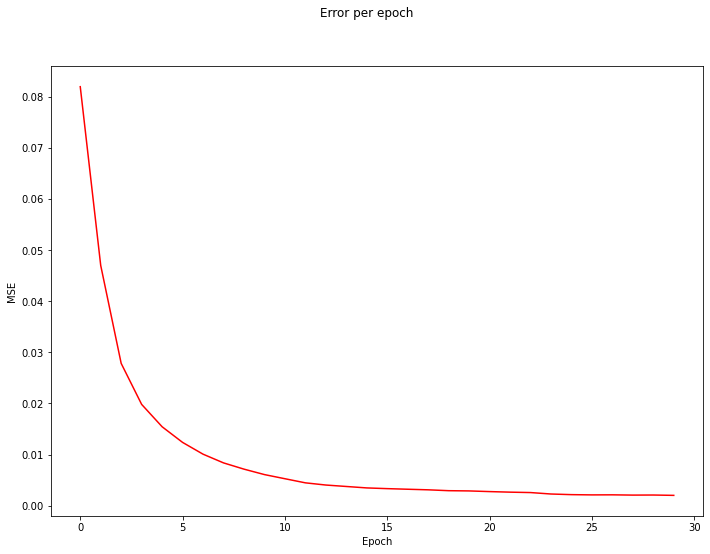

In [182]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'xavier'))
dnn.add(ActivationLayer('leaky_relu', 0.1))
dnn.add(FCLayer(128, 64, 'xavier'))
dnn.add(ActivationLayer('leaky_relu', 0.1))
dnn.add(FCLayer(64, n_classes, 'xavier'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

## Tanh activation

Epoch: 1, Time Spent: 0.53s, mse loss: 0.091190
Epoch: 2, Time Spent: 0.93s, mse loss: 0.090246
Epoch: 3, Time Spent: 1.33s, mse loss: 0.090229
Epoch: 4, Time Spent: 1.74s, mse loss: 0.090211
Epoch: 5, Time Spent: 2.12s, mse loss: 0.090189
Epoch: 6, Time Spent: 2.52s, mse loss: 0.090160
Epoch: 7, Time Spent: 2.90s, mse loss: 0.090117
Epoch: 8, Time Spent: 3.29s, mse loss: 0.090043
Epoch: 9, Time Spent: 3.67s, mse loss: 0.089894
Epoch: 10, Time Spent: 4.07s, mse loss: 0.089489
Epoch: 11, Time Spent: 4.45s, mse loss: 0.087861
Epoch: 12, Time Spent: 4.83s, mse loss: 0.082824
Epoch: 13, Time Spent: 5.28s, mse loss: 0.077078
Epoch: 14, Time Spent: 5.84s, mse loss: 0.069524
Epoch: 15, Time Spent: 6.28s, mse loss: 0.060792
Epoch: 16, Time Spent: 6.66s, mse loss: 0.052279
Epoch: 17, Time Spent: 7.05s, mse loss: 0.044261
Epoch: 18, Time Spent: 7.46s, mse loss: 0.038104
Epoch: 19, Time Spent: 7.84s, mse loss: 0.033299
Epoch: 20, Time Spent: 8.22s, mse loss: 0.028359
Epoch: 21, Time Spent: 8.59s,

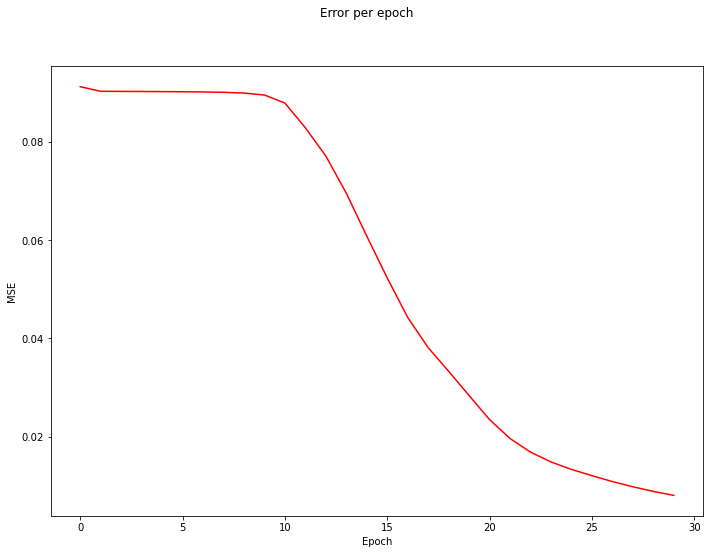

In [183]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'random'))
dnn.add(ActivationLayer('tanh'))
dnn.add(FCLayer(128, 64, 'random'))
dnn.add(ActivationLayer('tanh'))
dnn.add(FCLayer(64, n_classes, 'random'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

Epoch: 1, Time Spent: 0.42s, mse loss: 0.069144
Epoch: 2, Time Spent: 0.79s, mse loss: 0.033175
Epoch: 3, Time Spent: 1.16s, mse loss: 0.021685
Epoch: 4, Time Spent: 1.54s, mse loss: 0.016423
Epoch: 5, Time Spent: 1.91s, mse loss: 0.012912
Epoch: 6, Time Spent: 2.28s, mse loss: 0.010440
Epoch: 7, Time Spent: 2.68s, mse loss: 0.008501
Epoch: 8, Time Spent: 3.07s, mse loss: 0.006953
Epoch: 9, Time Spent: 3.45s, mse loss: 0.005899
Epoch: 10, Time Spent: 3.83s, mse loss: 0.005111
Epoch: 11, Time Spent: 4.21s, mse loss: 0.004504
Epoch: 12, Time Spent: 4.63s, mse loss: 0.004045
Epoch: 13, Time Spent: 5.11s, mse loss: 0.003722
Epoch: 14, Time Spent: 5.51s, mse loss: 0.003495
Epoch: 15, Time Spent: 5.89s, mse loss: 0.003330
Epoch: 16, Time Spent: 6.27s, mse loss: 0.003198
Epoch: 17, Time Spent: 6.67s, mse loss: 0.003082
Epoch: 18, Time Spent: 7.06s, mse loss: 0.002896
Epoch: 19, Time Spent: 7.45s, mse loss: 0.002749
Epoch: 20, Time Spent: 7.85s, mse loss: 0.002618
Epoch: 21, Time Spent: 8.25s,

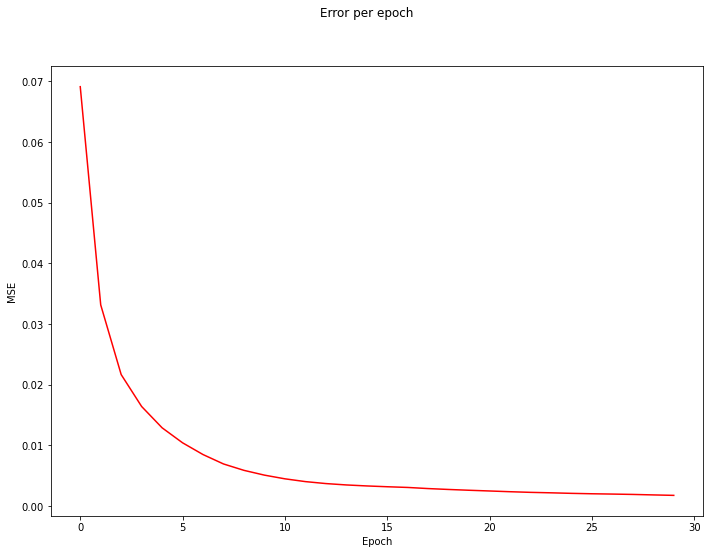

In [184]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'he'))
dnn.add(ActivationLayer('tanh'))
dnn.add(FCLayer(128, 64, 'he'))
dnn.add(ActivationLayer('tanh'))
dnn.add(FCLayer(64, n_classes, 'he'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

Epoch: 1, Time Spent: 0.45s, mse loss: 0.079817
Epoch: 2, Time Spent: 0.85s, mse loss: 0.045053
Epoch: 3, Time Spent: 1.22s, mse loss: 0.027279
Epoch: 4, Time Spent: 1.60s, mse loss: 0.019252
Epoch: 5, Time Spent: 2.00s, mse loss: 0.015045
Epoch: 6, Time Spent: 2.42s, mse loss: 0.012143
Epoch: 7, Time Spent: 2.79s, mse loss: 0.009930
Epoch: 8, Time Spent: 3.17s, mse loss: 0.008219
Epoch: 9, Time Spent: 3.54s, mse loss: 0.006930
Epoch: 10, Time Spent: 3.91s, mse loss: 0.005927
Epoch: 11, Time Spent: 4.29s, mse loss: 0.005235
Epoch: 12, Time Spent: 4.66s, mse loss: 0.004707
Epoch: 13, Time Spent: 5.04s, mse loss: 0.004244
Epoch: 14, Time Spent: 5.43s, mse loss: 0.003816
Epoch: 15, Time Spent: 5.81s, mse loss: 0.003397
Epoch: 16, Time Spent: 6.18s, mse loss: 0.003104
Epoch: 17, Time Spent: 6.55s, mse loss: 0.002846
Epoch: 18, Time Spent: 6.93s, mse loss: 0.002634
Epoch: 19, Time Spent: 7.30s, mse loss: 0.002472
Epoch: 20, Time Spent: 7.67s, mse loss: 0.002345
Epoch: 21, Time Spent: 8.04s,

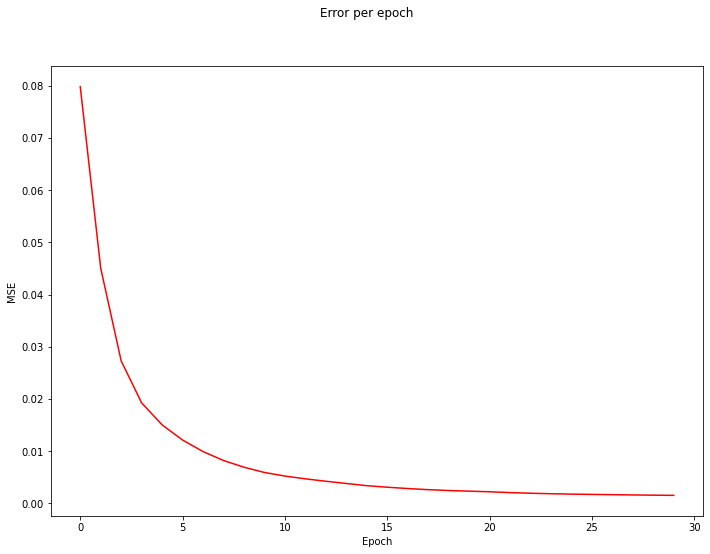

In [185]:
dnn = NeuralNetwork(epochs, lr)
dnn.add(FlattenLayer(input_shape=(28, 28)))
dnn.add(FCLayer(28 * 28, 128, 'xavier'))
dnn.add(ActivationLayer('tanh'))
dnn.add(FCLayer(128, 64, 'xavier'))
dnn.add(ActivationLayer('tanh'))
dnn.add(FCLayer(64, n_classes, 'xavier'))
dnn.add(Softmax(n_classes))
dnn.fit(x_train, y_train, 'mse')

print("Train Set accuracy:", dnn.compute_accuracy(x_train, y_train))
print("Test Set accuracy:", dnn.compute_accuracy(x_test, y_test))

dnn.visualize_learning()

As we can see, the best performing neural network used 'he' weights initialization and the hyperbloc tangent activation function. Its Train Set accuracy was 0.988 while the Test Set accuracy: 0.8731. It could probably be still improved with a better tuning of the network by changing the learning rate and/or the architectur (adding or subtracting layers, using wider or narrower layers).